# Agent

In this notebook, **we're going to build a simple agent using using LangGraph**.

This notebook is part of the <a href="https://www.hf.co/learn/agents-course">Hugging Face Agents Course</a>, a free course from beginner to expert, where you learn to build Agents.

![Agents course share](https://huggingface.co/datasets/agents-course/course-images/resolve/main/en/communication/share.png)

As seen in the Unit 1, an agent needs 3 steps as introduced in the ReAct architecture :
[ReAct](https://react-lm.github.io/), a general agent architecture.

* `act` - let the model call specific tools
* `observe` - pass the tool output back to the model
* `reason` - let the model reason about the tool output to decide what to do next (e.g., call another tool or just respond directly)


![Agent](https://huggingface.co/datasets/agents-course/course-images/resolve/main/en/unit2/LangGraph/Agent.png)

In [39]:
%pip install -q -U langchain_openai langchain_core langgraph

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [40]:
import os

# Please setp your own key.
os.environ["OPENAI_API_KEY"] = "sk-xxxxxx"

In [41]:
import base64
from langchain_core.messages import HumanMessage
from langchain_openai import ChatOpenAI

vision_llm = ChatOpenAI(model="gpt-4o", openai_api_base="https://api.chatanywhere.tech/v1")


def extract_text(img_path: str) -> str:
    """
    函数使用多模态模型从图像文件中提取文本内容

    Args:
        img_path: 本地图像文件路径（字符串类型）

    Returns:
        返回一个字符串，包含从每个图像中提取的连接文本
    """
    all_text = ""
    try:

        # 读取图像并编码为 base64
        with open(img_path, "rb") as image_file:
            image_bytes = image_file.read()

        image_base64 = base64.b64encode(image_bytes).decode("utf-8")

        # 准备包含 base64 图像数据的提示
        message = [
            HumanMessage(
                content=[
                    {
                        "type": "text",
                        "text": (
                            "Extract all the text from this image. "
                            "Return only the extracted text, no explanations."
                        ),
                    },
                    {
                        "type": "image_url",
                        "image_url": {
                            "url": f"data:image/png;base64,{image_base64}"
                        },
                    },
                ]
            )
        ]

        # 调用具有视觉功能的模型
        response = vision_llm.invoke(message)

        # 附加提取的文本
        all_text += response.content + "\n\n"

        return all_text.strip()
    except Exception as e:
        # 管家应优雅地处理错误
        error_msg = f"Error extracting text: {str(e)}"
        print(error_msg)
        return ""


llm = ChatOpenAI(model="gpt-4o")


def divide(a: int, b: int) -> float:
    """Divide a and b."""
    return a / b

# 定义可用的工具列表，供AI助手调用
tools = [
    divide,   # 除法计算工具
    extract_text  # 图像文本提取工具
]
# 将工具绑定到大语言模型，禁用并行工具调用以确保顺序执行
llm_with_tools = llm.bind_tools(tools, parallel_tool_calls=False)

Let's create our LLM and prompt it with the overall desired agent behavior.

In [42]:
from typing import TypedDict, Annotated, Optional
from langchain_core.messages import AnyMessage
from langgraph.graph.message import add_messages

# 定义智能体状态的数据结构，继承自TypedDict
class AgentState(TypedDict):
    # 输入文档
    input_file: Optional[str]   # 包含文件路径，类型(PNG)
    # 消息列表，使用add_messages装饰器进行标注
    messages: Annotated[list[AnyMessage], add_messages]

In [43]:
from langchain_core.messages import HumanMessage, SystemMessage
from langchain_core.utils.function_calling import convert_to_openai_tool

# 定义助手函数，接收AgentState类型的参数
def assistant(state: AgentState):
    # 系统消息
    # 定义工具描述文本，包含extract_text和divide两个工具的功能说明
    textual_description_of_tool = """
extract_text(img_path: str) -> str:
    Extract text from an image file using a multimodal model.

    Args:
        img_path: A local image file path (strings).

    Returns:
        A single string containing the concatenated text extracted from each image.
divide(a: int, b: int) -> float:
    Divide a and b
"""

    # 获取状态中的输入文件
    image = state["input_file"]
    # 创建系统消息，告知AI助手可用工具及当前加载的图像信息
    sys_msg = SystemMessage(content=f"You are an helpful agent that can analyse some images and run some computatio without provided tools :\n{textual_description_of_tool} \n You have access to some otpional images. Currently the loaded images is : {image}")

    # 返回处理结果，包含消息和输入文件信息
    res = {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])], "input_file": state["input_file"]}
    print("<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<")
    print(res)
    print(">>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>")
    return res

We define a `tools` node with our list of tools.

The `assistant` node is just our model with bound tools.

We create a graph with `assistant` and `tools` nodes.

We add `tools_condition` edge, which routes to `End` or to `tools` based on  whether the `assistant` calls a tool.

Now, we add one new step:

We connect the `tools` node *back* to the `assistant`, forming a loop.

* After the `assistant` node executes, `tools_condition` checks if the model's output is a tool call.
* If it is a tool call, the flow is directed to the `tools` node.
* The `tools` node connects back to `assistant`.
* This loop continues as long as the model decides to call tools.
* If the model response is not a tool call, the flow is directed to END, terminating the process.

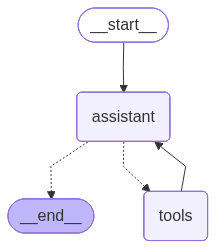

In [44]:
from langgraph.graph import START, StateGraph
from langgraph.prebuilt import ToolNode, tools_condition
from IPython.display import Image, display

# Graph
builder = StateGraph(AgentState)

# 定义节点：这些节点完成工作
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))

# 添加条件边，基于assistant节点的输出决定流向
builder.add_edge(START, "assistant")

# tools_condition：判断 assistant 最新的 AIMessage 是否包含 tool_calls，若包含，表示模型已显式请求调用工具，应路由到 tool 节点；否则直接结束并返回结果
# tools_condition 的职责是：判断当前 assistant 节点产出的最新 AIMessage 是否包含「未执行的工具调用意图」，从而决定状态机是否需要跳转到 tool 节点执行外部工具。
builder.add_conditional_edges(
    "assistant",
    # 如果最新消息需要工具，则路由至工具
    # 否则，请直接回复
    tools_condition,
)

# 添加边：从tools节点回到assistant节点，形成循环
builder.add_edge("tools", "assistant")
# 编译图，生成可执行的反应式图
react_graph = builder.compile()

# Show
display(Image(react_graph.get_graph(xray=True).draw_mermaid_png()))

In [45]:
# 创建一个包含人类消息的列表，内容为"Divide 6790 by 5"
messages = [HumanMessage(content="Divide 6790 by 5")]

# 调用反应图，传入消息和输入文件为空，启动智能体处理流程
messages = react_graph.invoke({"messages": messages, "input_file": None})

<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
{'messages': [AIMessage(content='', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 19, 'prompt_tokens': 204, 'total_tokens': 223, 'completion_tokens_details': {'accepted_prediction_tokens': None, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': None}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_4a331a0222', 'id': 'chatcmpl-CzNLom68kHo0JWQP0CilQTxg3aA50', 'finish_reason': 'tool_calls', 'logprobs': None}, id='lc_run--019bd158-a862-71a2-b669-145f88d11f90-0', tool_calls=[{'name': 'divide', 'args': {'a': 6790, 'b': 5}, 'id': 'call_iJ2F7STAkBxQ61hf10znMoet', 'type': 'tool_call'}], invalid_tool_calls=[], usage_metadata={'input_tokens': 204, 'output_tokens': 19, 'total_tokens': 223, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_

In [46]:
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Divide 6790 by 5
================================== Ai Message ==================================
Tool Calls:
  divide (call_iJ2F7STAkBxQ61hf10znMoet)
 Call ID: call_iJ2F7STAkBxQ61hf10znMoet
  Args:
    a: 6790
    b: 5
================================= Tool Message =================================
Name: divide

1358.0
================================== Ai Message ==================================

6790 divided by 5 equals 1358.0.


## Training program
MR Wayne left a note with his training program for the week. I came up with a recipe for dinner left in a note.

you can find the document [HERE](https://huggingface.co/datasets/agents-course/course-images/blob/main/en/unit2/LangGraph/Batman_training_and_meals.png), so download it and upload it in the local folder.

![Training](https://huggingface.co/datasets/agents-course/course-images/resolve/main/en/unit2/LangGraph/Batman_training_and_meals.png)

In [47]:
# messages = [HumanMessage(content="According the note provided by MR wayne in the provided images. What's the list of items I should buy for the dinner menu ?")]
#
# messages = react_graph.invoke({"messages": messages, "input_file": "Batman_training_and_meals.png"})

In [48]:
# for m in messages['messages']:
#     m.pretty_print()